In [1]:
import warnings
import numpy as np 
import matplotlib.pyplot as plt 
import utils
import metric 
import torch 
import dataloader 
from batchgenerators.dataloading.multi_threaded_augmenter import MultiThreadedAugmenter
import segmentation_models_pytorch as smp
from torchsummary import summary
import time
import math 
import pandas as pd 
import wandb
from tqdm import tqdm
from torch import nn
from sklearn.metrics import precision_recall_fscore_support, jaccard_score
from scipy.spatial.distance import directed_hausdorff
from matplotlib.lines import Line2D
import seaborn as sns
%matplotlib inline

# Hyperparameters

Hyperparameter tuning with wandb sweep techniques, using grid search. The hyperparameters tuned are as below:
- batch size: [4, 8, 16]
- learning rate: [1e-2, 1e-3, le-4, 1e-5]
- encoder model: [resnet18, resnet34, resnet50]

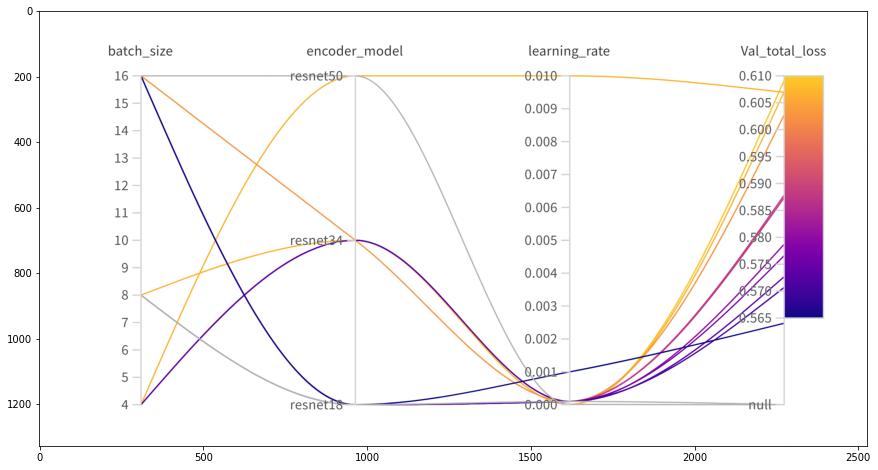

In [2]:
plt.figure(figsize=(15, 8))
plt.imshow(np.array(plt.imread('fig/hyperparam_tuning.png')))

Best hyperparameter:
- batch size: 16
- encoder model: resnet 18
- learning rate: 0.001 

For learning rate scheduling, I adapted reduce learning rate on plataeu with patience of 20. 

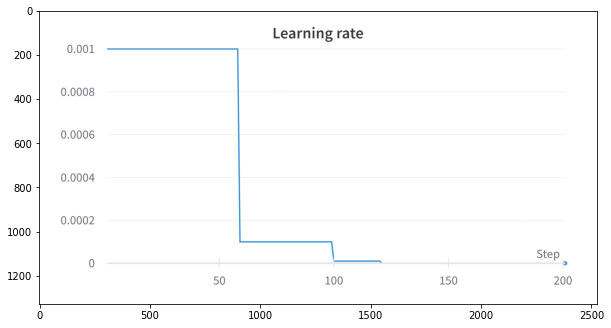

In [3]:
plt.figure(figsize=(10, 8))
plt.imshow(np.array(plt.imread('fig/learning_rate.png')))

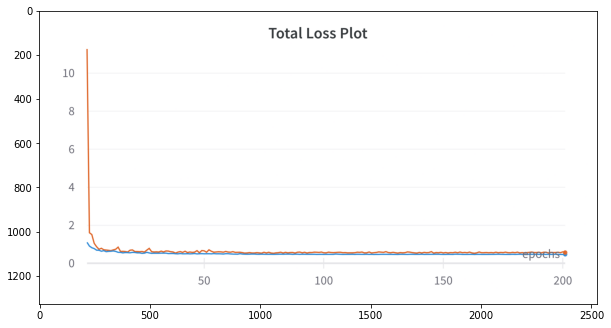

In [4]:
plt.figure(figsize=(10, 8))
plt.imshow(np.array(plt.imread('fig/total_loss_plot.png')))

In [5]:
# load hyperparams
batch_size = 16
patch_size = (512, 512)
encoder_model = 'resnet18'
n_class = 1
test_fol = 'testB_ds'
weight_path = 'weights/best_weight.pth'

# Model Building 

In [6]:
warnings.filterwarnings('ignore')
tabular_data = pd.read_csv('data.csv')
ds_dict = dataloader.get_split_fold(tabular_data)
val_dl = dataloader.DataLoader(data=ds_dict[test_fol], batch_size=batch_size, patch_size=patch_size,
                               num_threads_in_multithreaded=1, seed_for_shuffle=5243,
                               return_incomplete=True, shuffle=False, infinite=False)
# Get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
# define model
model = smp.Unet(encoder_name=encoder_model, decoder_use_batchnorm=True,
                 in_channels=3, classes=n_class).to(device)

The model choice is UNet architecture with trainable parameters of around 14 million. 

In [7]:
summary(model, (3, 512, 512))

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNetEncoder: 1-1                     [-1, 3, 512, 512]         --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-3                         [-1, 64, 256, 256]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 128, 128]        --
|    └─Sequential: 2-5                   [-1, 64, 128, 128]        --
|    |    └─BasicBlock: 3-1              [-1, 64, 128, 128]        73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 128, 128]        73,984
|    └─Sequential: 2-6                   [-1, 128, 64, 64]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 64, 64]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 64, 64]         295,424
|    └─Sequential: 2-7                   [-1, 256, 32, 32]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 32, 32]     

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNetEncoder: 1-1                     [-1, 3, 512, 512]         --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-3                         [-1, 64, 256, 256]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 128, 128]        --
|    └─Sequential: 2-5                   [-1, 64, 128, 128]        --
|    |    └─BasicBlock: 3-1              [-1, 64, 128, 128]        73,984
|    |    └─BasicBlock: 3-2              [-1, 64, 128, 128]        73,984
|    └─Sequential: 2-6                   [-1, 128, 64, 64]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 64, 64]         230,144
|    |    └─BasicBlock: 3-4              [-1, 128, 64, 64]         295,424
|    └─Sequential: 2-7                   [-1, 256, 32, 32]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 32, 32]     

# Validation

The loss function used is dice loss and soft binary cross entropy (BCE + label smooting). 

In [8]:
# xent = nn.BCELoss()
dice_loss = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
# label smoothing
xent = smp.losses.SoftBCEWithLogitsLoss(smooth_factor=0.1)

def custom_loss(pred, target):
    xent_l = xent(pred, target)
    dice_l = dice_loss(pred, target)
    loss = xent_l + dice_l
    return loss, xent_l, dice_l

def test(model):
    num_batches = math.ceil(len(ds_dict[test_fol]['img_npy']) / batch_size)
    model.eval()
    test_loss, correct = 0, 0
    # no need back prop for testing set
    batch_xent_l = []
    batch_dice_l = []
    batch_loss = []
    imgs_list = []
    segs_list = []
    pred_list = []
    segs_ori_list = []
    print("Testing...")
    with torch.no_grad():
        for i in tqdm(range(num_batches)):
            val_batch = next(val_dl)
            imgs = val_batch['data']
            segs = val_batch['seg']
            segs_ori = segs 
            # normalization
            imgs = utils.min_max_norm(imgs)
            # binarisation
            segs = np.where(segs > 0., 1.0, 0.).astype('float32')
            segs = np.expand_dims(segs[:, 0, :, :], 1)
            imgs, segs = torch.from_numpy(imgs).to(device), torch.from_numpy(segs).to(device)
            # Compute loss
            pred = model(imgs)
            loss, xent_l, dice_l = custom_loss(pred, segs)
            # batch losses
            batch_xent_l.append(xent_l)
            batch_dice_l.append(dice_l)
            batch_loss.append(loss)
            # accumulate outputs for each batch
            imgs_list.append(imgs.cpu().detach().numpy())
            segs_list.append(segs.cpu().detach().numpy())
            pred_list.append(pred.cpu().detach().numpy())
            segs_ori_list.append(segs_ori)
        # apply sigmoid to masking
        segs = nn.Sigmoid()(segs)
        # taking the average along the batch
        loss = torch.mean(torch.as_tensor(batch_loss)).item()
        avg_xent_l = torch.mean(torch.as_tensor(batch_xent_l)).item()
        avg_dice_l = torch.mean(torch.as_tensor(batch_dice_l)).item()
    return {'loss': loss, 'xent_l': avg_xent_l, 'dice_l': avg_dice_l,
            'imgs': imgs_list,
            'segs': segs_list,
            'pred': pred_list,
            'segs_ori': segs_ori_list
            }

In [9]:
model.load_state_dict(torch.load(weight_path))
start = time.time()
test_output = test(model)
print("Runtime: {} s".format(time.time()-start))
print("Total loss: {:.2f}, BCE: {:.2f}, Dice Loss: {:2f}".format(test_output['loss'], 
    test_output['xent_l'], test_output['dice_l']))

  0%|          | 0/2 [00:00<?, ?it/s]

Testing...


100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

Runtime: 0.42966556549072266 s
Total loss: 0.69, BCE: 0.55, Dice Loss: 0.134812


In [10]:
# channel last for image plotting 
swap = (lambda x: np.einsum('bchw->bhwc', x))
repeat_channel = (lambda x: np.repeat(x, 3, axis=-1))
# stack the image along the batch axis 
total_segs = swap(np.vstack(tuple(test_output['segs_ori'])))
total_imgs = swap(np.vstack(tuple(test_output['imgs'])))
total_pred = repeat_channel(swap(np.where(np.vstack(tuple(test_output['pred']))>0.5, 1.0, 0.0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


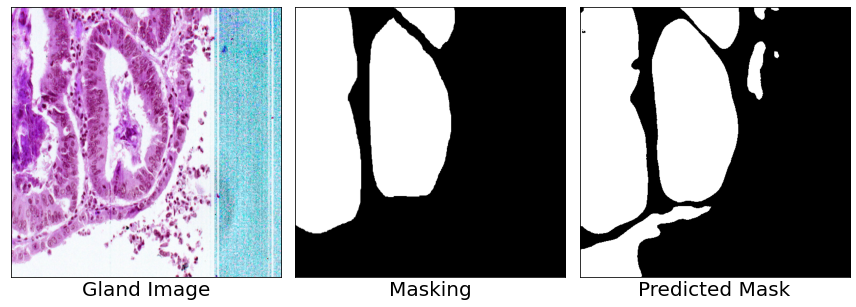

In [11]:
# sanity check for predicted output 
imgs = [total_imgs[0], total_segs[0], total_pred[0]]
captions = ['Gland Image', 'Masking', 'Predicted Mask']
utils.plot_comparison(imgs, captions, n_col=len(imgs), figsize=(12, 12), cmap=None)

## Results 

In [12]:
# Calculate the pixel-wise Precision, Recall, F1-score and Hausdorff Distance
ori_mask = repeat_channel(swap(np.vstack(tuple(test_output['segs'])))) # binarised masking
pred_mask = total_pred
p_list = [] # precision list
r_list = [] # recall list
f_list = [] # f1 score list
hd_list = [] # hausdorff list
ds_list = [] # dice score list 
for i in range(len(ori_mask)): 
    p, r, f, _ = precision_recall_fscore_support(ori_mask[i][:,:,0].flatten().astype('uint8'), 
                                              pred_mask[i][:,:,0].flatten().astype('uint8'),
                                             average='micro')
    ds = metric.Dice(ori_mask[i][:,:,0].flatten().astype('uint8'), 
                       pred_mask[i][:,:,0].flatten().astype('uint8'))
    hd = metric.Hausdorff(ori_mask[i][:,:,0], 
                           pred_mask[i][:,:,0])
    p_list.append(p)
    r_list.append(r)
    f_list.append(f)
    hd_list.append(hd)
    ds_list.append(ds)

print("Dataset: {}".format(test_fol))
print('-'*20)
print("Precision: {:.2f} ({:.2f})".format(np.mean(p_list), np.std(p_list)))
print("Recall: {:.2f} ({:.2f})".format(np.mean(r_list),  np.std(r_list)))
print("F1-score: {:.2f} ({:.2f})".format(np.mean(f_list),  np.std(p_list)))
print("Dice score: {:.2f} ({:.2f})".format(np.mean(ds_list),  np.std(ds_list)))
print("Hausdorff Distance: {:.2f} ({:.2f})".format(np.mean(hd_list),  np.std(hd_list)))

Dataset: testB_ds
--------------------
Precision: 0.90 (0.08)
Recall: 0.90 (0.08)
F1-score: 0.90 (0.08)
Dice score: 0.91 (0.07)
Hausdorff Distance: 68.31 (33.02)


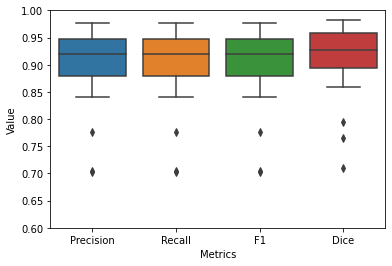

In [22]:
# box plot 
data = {'Precision': p_list,
             'Recall': r_list,
             'F1': f_list,
             'Dice': ds_list}
metric_df = pd.DataFrame(data)
metric_df = pd.melt(metric_df)
# rename column 
metric_df.rename(columns = {'variable':'Metrics', 'value': 'Value'}, inplace = True)
sns.boxplot(x="Metrics", y="Value", data=metric_df)
plt.ylim(0.6, 1.0)
plt.show()

## Visualisation 

### Lowest Dice Score 

Binarised Segmentation Results:



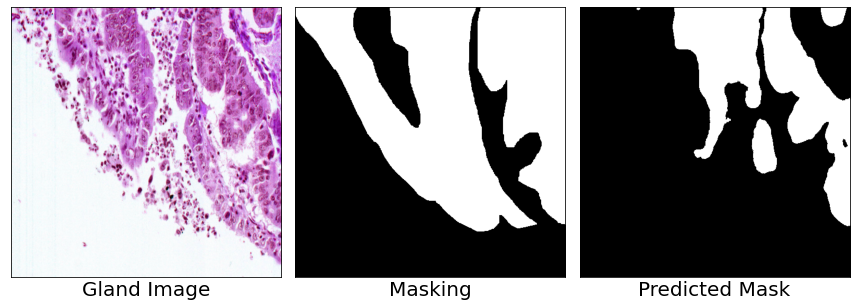

Overlay Results:



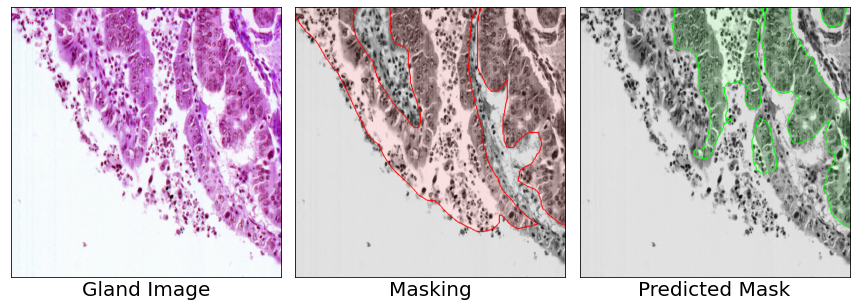

Hausdorff Distance:


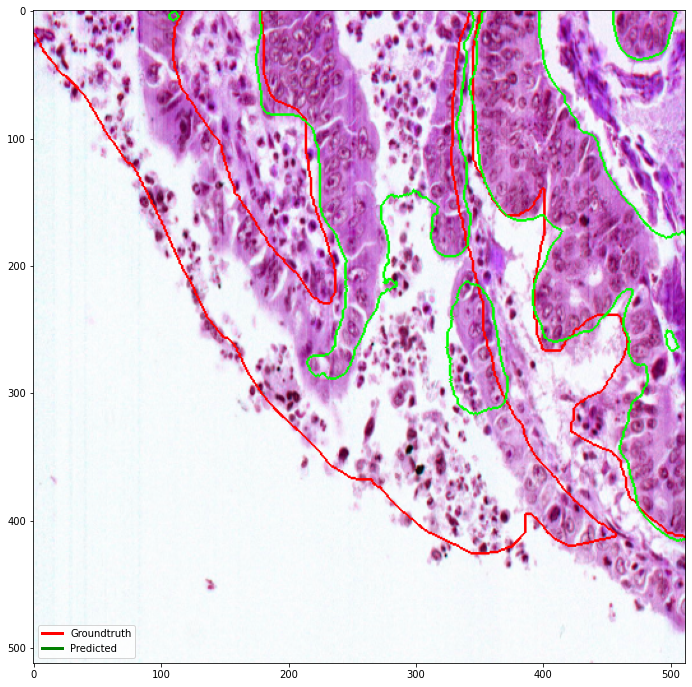

Metric Results:
---------------
Precision: 0.72, Recall: 0.72, F1 Score:0.72, Dice Score: 0.61, Hausdorff Distance:122.0245876862528


In [20]:
# pick the index for the lowest dice score
min_ds_idx = np.argmin(ds_list)

print("Binarised Segmentation Results:")
imgs = [total_imgs[min_ds_idx], ori_mask[min_ds_idx], pred_mask[min_ds_idx]]
captions = ['Gland Image', 'Masking', 'Predicted Mask']
utils.plot_comparison(imgs, captions, n_col=len(imgs), figsize=(12, 12), cmap=None)

print("Overlay Results:")
ori_overlay_img = utils.overlay_boundary(utils.overlay_mask(total_imgs[min_ds_idx], 
                                         ori_mask[min_ds_idx], alpha=0.1,
                                         colors=[(1.0, 0, 0)]), ori_mask[min_ds_idx],
                                         color=(1.0,0,0))
pred_overlay_img = utils.overlay_boundary(utils.overlay_mask(total_imgs[min_ds_idx], 
                                          pred_mask[min_ds_idx], alpha=0.1), pred_mask[min_ds_idx])
imgs = [total_imgs[min_ds_idx], ori_overlay_img, pred_overlay_img]
captions = ['Gland Image', 'Masking', 'Predicted Mask']
utils.plot_comparison(imgs, captions, n_col=len(imgs), figsize=(12, 12), cmap=None)                                                                                        
                                                                                        
print("Hausdorff Distance:")
legend_elements = [Line2D([0], [0], color='r', lw=3, label='Groundtruth'),
                   Line2D([0], [0], color='g', lw=3, label='Predicted')]
ori_boundary_img = utils.overlay_boundary(total_imgs[min_ds_idx], ori_mask[min_ds_idx],
                                         color=(1.0,0,0))
# supervimposed predicted boundary on ori boundary 
pred_boundary_img = utils.overlay_boundary(ori_boundary_img, pred_mask[min_ds_idx])
plt.figure(figsize=(12, 12))
plt.imshow(pred_boundary_img)
plt.legend(handles=legend_elements, loc='lower left')
plt.show()
print("Metric Results:")
print("---------------")
print("Precision: {:.2f}, Recall: {:.2f}, F1 Score:{:.2f}, Dice Score: {:.2f}, Hausdorff Distance:{}".format(p_list[min_ds_idx], 
                                                                                                                r_list[min_ds_idx],
                                                                                                                f_list[min_ds_idx],
                                                                                                                ds_list[min_ds_idx],
                                                                                                                hd_list[min_ds_idx]))

### Highest Dice Score 

Binarised Segmentation Results:



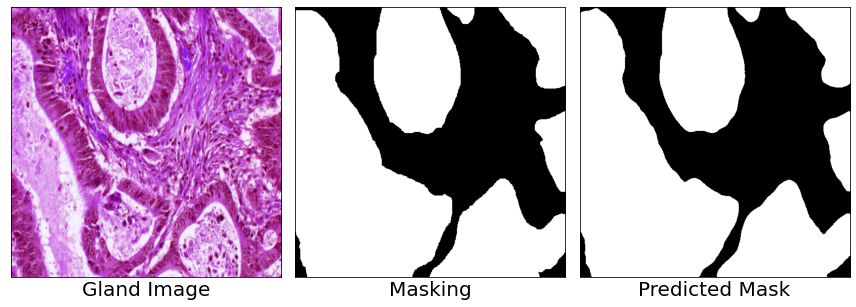

Overlay Results:



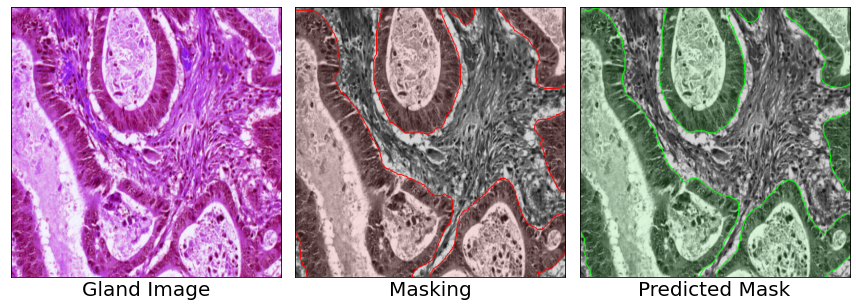

Hausdorff Distance:


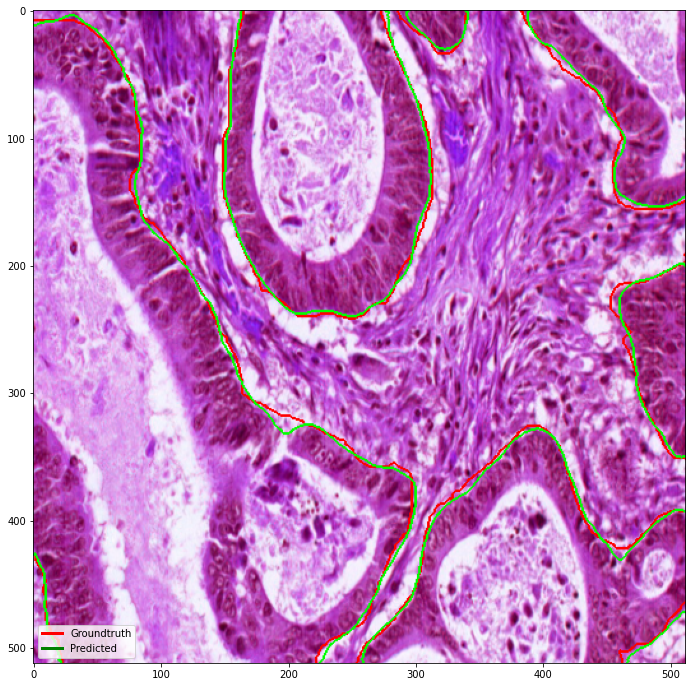

Metric Results:
---------------
Precision: 0.98, Recall: 0.98, F1 Score:0.98, Dice Score: 0.99, Hausdorff Distance:11.661903789690601


In [19]:
# pick the index for the lowest dice score
max_ds_idx = np.argmax(ds_list)

print("Binarised Segmentation Results:")
imgs = [total_imgs[max_ds_idx], ori_mask[max_ds_idx], pred_mask[max_ds_idx]]
captions = ['Gland Image', 'Masking', 'Predicted Mask']
utils.plot_comparison(imgs, captions, n_col=len(imgs), figsize=(12, 12), cmap=None)

print("Overlay Results:")
ori_overlay_img = utils.overlay_boundary(utils.overlay_mask(total_imgs[max_ds_idx], 
                                         ori_mask[max_ds_idx], alpha=0.1,
                                         colors=[(1.0, 0, 0)]), ori_mask[max_ds_idx],
                                         color=(1.0,0,0))
pred_overlay_img = utils.overlay_boundary(utils.overlay_mask(total_imgs[max_ds_idx], 
                                          pred_mask[max_ds_idx], alpha=0.1), pred_mask[max_ds_idx])
imgs = [total_imgs[max_ds_idx], ori_overlay_img, pred_overlay_img]
captions = ['Gland Image', 'Masking', 'Predicted Mask']
utils.plot_comparison(imgs, captions, n_col=len(imgs), figsize=(12, 12), cmap=None)                                                                                        
                                                                                        
print("Hausdorff Distance:")
legend_elements = [Line2D([0], [0], color='r', lw=3, label='Groundtruth'),
                   Line2D([0], [0], color='g', lw=3, label='Predicted')]
ori_boundary_img = utils.overlay_boundary(total_imgs[max_ds_idx], ori_mask[max_ds_idx],
                                         color=(1.0,0,0))
# supervimposed predicted boundary on ori boundary 
pred_boundary_img = utils.overlay_boundary(ori_boundary_img, pred_mask[max_ds_idx])
plt.figure(figsize=(12, 12))
plt.imshow(pred_boundary_img)
plt.legend(handles=legend_elements, loc='lower left')
plt.show()

print("Metric Results:")
print("---------------")
print("Precision: {:.2f}, Recall: {:.2f}, F1 Score:{:.2f}, Dice Score: {:.2f}, Hausdorff Distance:{}".format(p_list[max_ds_idx], 
                                                                                                                r_list[max_ds_idx],
                                                                                                                f_list[max_ds_idx],
                                                                                                                ds_list[max_ds_idx],
                                                                                                                hd_list[max_ds_idx]))

# Future Work
Gland-wise segmentation results using custom written code for evaluation seems too good to be true. The overall results is better than pixel-wise segmentation results and the results during the GlaS2015 challenge (paper: https://www.researchgate.net/publication/301841306_Gland_Segmentation_in_Colon_Histology_Images_The_GlaS_Challenge_Contest). This section serves as a demonstration on how binarised segmentatin results can be converted to gland-wise segmentation and the metrics to calculate gland-wise segmentation serves as future reference. 

In [16]:
# convert binary segmentation to gland-level label by finding the intersection 
# between the original masking and the predicted masking, if overlap, the 
# area is assigned to the labels samed as the original masking, else => 0
pred_multi = np.where((total_segs>0.) & (total_pred==1.0), total_segs, 0.0)

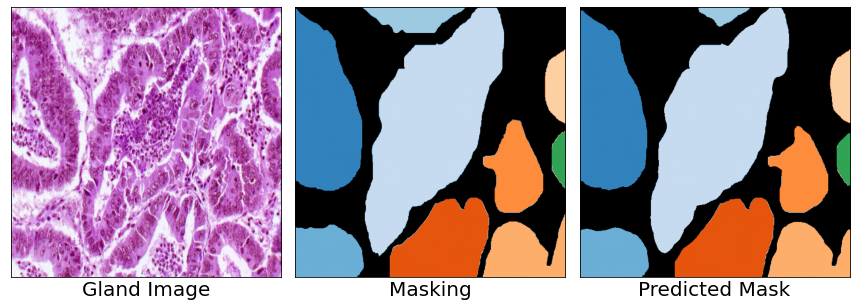

In [17]:
seg_color = utils.plot_labels_color(total_segs[1].astype('uint8'))
pred_color = utils.plot_labels_color(pred_multi[1].astype('uint8'))
imgs = [total_imgs[1], seg_color, pred_color]
captions = ['Gland Image', 'Masking', 'Predicted Mask']
utils.plot_comparison(imgs, captions, n_col=len(imgs), figsize=(12, 12), cmap=None)

In [18]:
obj_ds_list = []
obj_hd_list = []
obj_f_list = []
for i in range(len(pred_multi)): 
    obj_dice = metric.ObjectDice(pred_multi[i], total_segs[i])
    obj_hd = metric.ObjectHausdorff(pred_multi[i], total_segs[i])
    obj_f = metric.F1score(pred_multi[i], total_segs[i])
    obj_ds_list.append(obj_dice)
    obj_hd_list.append(obj_hd)
    obj_f_list.append(obj_f)
print("Object F1-score: {:.2f}".format(np.mean(obj_f_list)))
print("Object Dice score: {:.2f}".format(np.mean(obj_ds_list)))
print("Object Hausdorff Distance: {:.2f}".format(np.mean(obj_hd_list)))

Object F1-score: 0.93
Object Dice score: 0.95
Object Hausdorff Distance: 56.25
